In [35]:
!pip install cffi==1.15.1
!pip install mip
!pip install gurobipy

import numpy as np
import pandas as pd
from mip import *
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(42)



# Importando Dados

In [36]:
df=pd.read_csv('https://raw.githubusercontent.com/Fernandovilelab/I-Simp-sio-Geomet/main/Data.csv')
df_backup=df.copy()
df['destination'] = df['destination'].replace(2, 0)# Substituindo o destino pilha para 0
df['horas'] = np.random.uniform(8, 21, size=len(df))#Criando coluna horas aleatoria seguindo uma distribuição normal
df['ano'] =0
df_backup=df.copy()


# Definindo Precedencia de Blocos


In [37]:
precedence=df.copy()
precedence = precedence.drop(columns=['tonn','blockvalue','destination','CU%','process_profit','Profit','horas','ano'])

coords_to_id = {(row['x'], row['y'], row['z']): row['id'] for _, row in precedence.iterrows()}

In [38]:
precedence['prec1'] = list(zip(precedence['x'], precedence['y'], precedence['z'] + 1))
precedence['prec2'] = list(zip(precedence['x']-1, precedence['y']+1, precedence['z'] + 1))
precedence['prec3'] = list(zip(precedence['x']-1, precedence['y'], precedence['z'] + 1))
precedence['prec4'] = list(zip(precedence['x']-1, precedence['y']-1, precedence['z'] + 1))
precedence['prec5'] = list(zip(precedence['x'], precedence['y']+1, precedence['z'] + 1))
precedence['prec6'] = list(zip(precedence['x'], precedence['y']-1, precedence['z'] + 1))
precedence['prec7'] = list(zip(precedence['x']+1, precedence['y']+1, precedence['z'] + 1))
precedence['prec8'] = list(zip(precedence['x']+1, precedence['y'], precedence['z'] + 1))
precedence['prec9'] = list(zip(precedence['x']+1, precedence['y']-1, precedence['z'] + 1))


In [39]:
def replace_tuple(tuple_value):
    return coords_to_id.get(tuple_value, -1)

# Aplica a função em todas as colunas 'prec' do DataFrame
for col in precedence.columns:
    if col.startswith('prec'):
        precedence[col] = precedence[col].apply(replace_tuple).astype(int)

precedence_backup=precedence.copy()



In [40]:
def apagar_prec(dataframe, lista_numeros):
    # Filtra as colunas que começam com 'prec'
    colunas_prec = [col for col in dataframe.columns if col.startswith('prec')]

    # Substitui os valores nas colunas filtradas de acordo com a lista de números
    for coluna in colunas_prec:
        dataframe[coluna] = dataframe[coluna].apply(lambda x: -1 if x in lista_numeros else x)

    return dataframe

# Solver Gurobi


In [41]:
# Criando critério de parada para o laço considerando o pior caso(Todos blocos serão processados)
anos = df['tonn'].sum() / 10000000
anos=int(anos)+1
anos

23

In [42]:
params = {
"WLSACCESSID": '9f9c2245-22ce-4d25-9def-efb0a12c39d6',
"WLSSECRET": '42d0ad98-0a28-4682-99c2-e0346c355ed9',
"LICENSEID":2519005,
'OutputFlag': 0
}
env = gp.Env(params=params)



In [43]:
lucro_anual = []

# Loop pelos anos
for k in range(anos):
    block_id = list(df['id'].values)
    destination = list(df['destination'].values)
    profit = list(df['Profit'].values)
    tonn = list(df['tonn'].values)
    horas = list(df['horas'].values)

    # Modelo
    mine_model = gp.Model(env=env)

    # Definindo variáveis
    selected = mine_model.addVars(block_id, vtype=GRB.BINARY, name="selected")

    # Definindo a função objetivo
    mine_model.setObjective(gp.quicksum(selected[i] * profit[i] for i in block_id), GRB.MAXIMIZE)

    # Restrições de precedência
    for index, row in precedence.iterrows():
        for col in precedence.columns:
            if col.startswith('prec'):
                if row[col] != -1:
                    mine_model.addConstr(selected[row[col]] >= selected[row['id']])

    # Outras restrições
    mine_model.addConstr(gp.quicksum(destination[i] * horas[i] * selected[i] for i in block_id) <= 7884)
    mine_model.addConstr(gp.quicksum(destination[i] * tonn[i] * selected[i] for i in block_id) <= 10000000)
    mine_model.addConstr(gp.quicksum(horas[i] * selected[i] for i in block_id) <= 80000000)

    # Otimizar o modelo
    mine_model.optimize()

    if mine_model.status == GRB.OPTIMAL and mine_model.ObjVal > 0:
        print("Valor da função objetivo:", mine_model.ObjVal)
        lucro_anual.append(mine_model.ObjVal)

        removidos = []
        for index, i in enumerate(block_id):
            if selected[i].x > 0.6:  # Verifica se o bloco está selecionado
                df.at[index, 'Profit'] = 0  # Define o lucro para 0
                df.at[index, 'horas'] = 99999
                df.at[index, 'tonn'] = 100000000
                removidos.append(df.at[index, 'id'])
                if df.at[index, 'ano'] == 0:
                    df.at[index, 'ano'] = k + 1  # Define o ano como k + 1

        precedence = apagar_prec(precedence, removidos)
    else:
        break

    mine_model.reset()

Valor da função objetivo: 75707257.75783
Valor da função objetivo: 69710594.76678
Valor da função objetivo: 63960405.23712
Valor da função objetivo: 61702711.59968001
Valor da função objetivo: 59363626.07317999
Valor da função objetivo: 55314736.452827
Valor da função objetivo: 64697977.230620004
Valor da função objetivo: 57168758.76854999
Valor da função objetivo: 54574223.883779995
Valor da função objetivo: 50389121.207279995
Valor da função objetivo: 24622633.528400004


In [44]:
lucro_anual

[75707257.75783,
 69710594.76678,
 63960405.23712,
 61702711.59968001,
 59363626.07317999,
 55314736.452827,
 64697977.230620004,
 57168758.76854999,
 54574223.883779995,
 50389121.207279995,
 24622633.528400004]

In [45]:
vpl = 0
for t in range(len(lucro_anual)):
    vpl += lucro_anual[t] / ((1 + 0.15) ** t)
print(vpl)

374414559.1168343


## Visualizando Sequenciamento

In [46]:
df = df[df['ano'] != 0]

unique_years = df['ano'].unique()

fig = go.Figure(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        symbol='square',
        color=df['ano'],
        colorscale='Plasma',
        colorbar=dict(
            title='Ano de Processamento',
            tickvals=unique_years,
            ticktext=unique_years
        )
    ),
    text=['Ano: ' + str(year) for year in df['ano']]
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='Blocos Processados por Ano'
)

fig.show()

## Histograma

In [47]:
merged_df = pd.merge(df, df_backup, on='id')



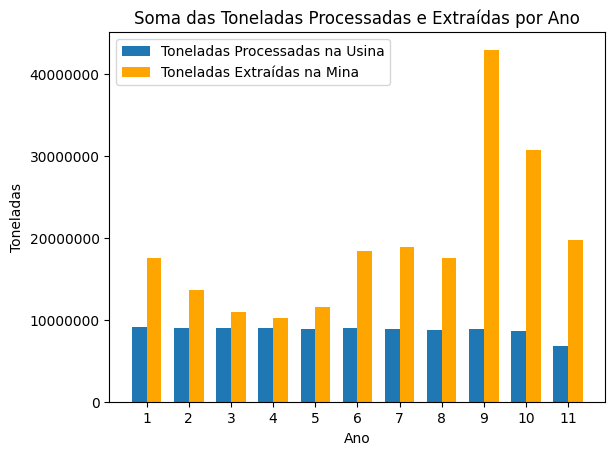

In [48]:
df_processados = merged_df.loc[(merged_df['ano_x'] > 0) & (merged_df['destination_x'] == 1)]

soma_por_ano_processados = df_processados.groupby('ano_x')['tonn_y'].sum()


df_extraidos = merged_df.loc[(merged_df['ano_x'] > 0) ]

soma_por_ano_extraidos = df_extraidos.groupby('ano_x')['tonn_y'].sum()

anos = sorted(set(soma_por_ano_processados.index) | set(soma_por_ano_extraidos.index))

toneladas_processadas = [soma_por_ano_processados.get(ano, 0) for ano in anos]
toneladas_extraidas = [soma_por_ano_extraidos.get(ano, 0) for ano in anos]

largura_barra = 0.35

posicoes = range(len(anos))

plt.bar(posicoes, toneladas_processadas, largura_barra, label='Toneladas Processadas na Usina')

plt.bar([posicao + largura_barra for posicao in posicoes], toneladas_extraidas, largura_barra, color='orange', label='Toneladas Extraídas na Mina')

plt.xlabel('Ano')
plt.ylabel('Toneladas')


plt.xticks([posicao + largura_barra / 2 for posicao in posicoes], anos)

plt.ticklabel_format(style='plain', axis='y')

plt.title('Soma das Toneladas Processadas e Extraídas por Ano')

plt.legend()

plt.show()


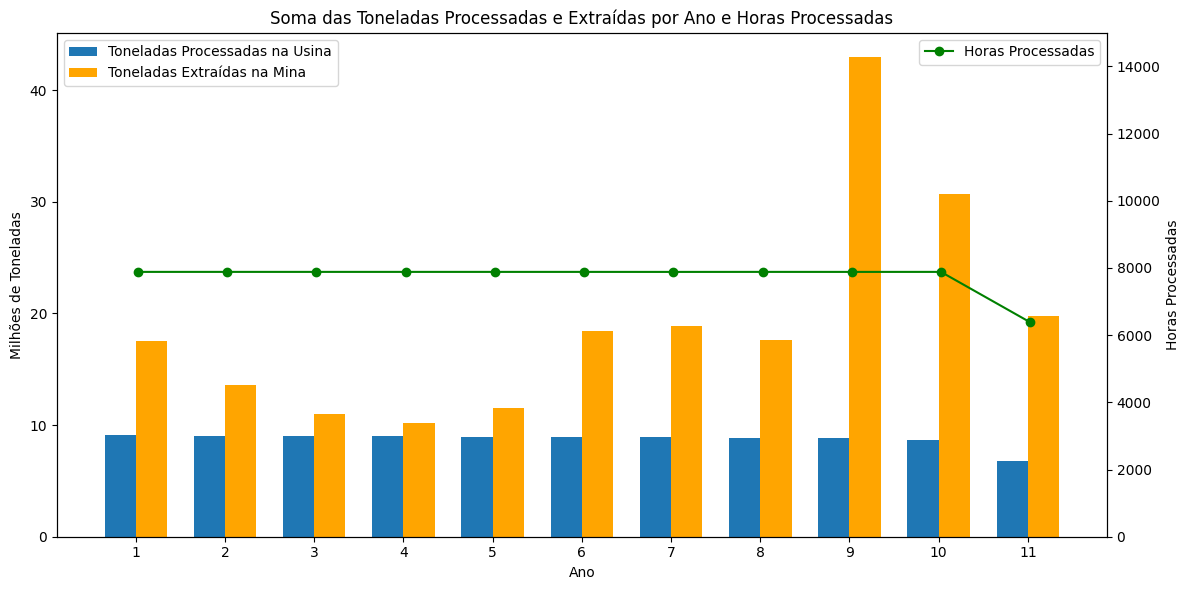

In [49]:
df_processados = merged_df.loc[(merged_df['ano_x'] > 0) & (merged_df['destination_x'] == 1)]
soma_por_ano_processados = df_processados.groupby('ano_x')['tonn_y'].sum()/1000000
soma_hora_processados = df_processados.groupby('ano_x')['horas_y'].sum()

df_extraidos = merged_df.loc[(merged_df['ano_x'] > 0)]
soma_por_ano_extraidos = df_extraidos.groupby('ano_x')['tonn_y'].sum()/1000000

anos = sorted(set(soma_por_ano_processados.index) | set(soma_por_ano_extraidos.index))
toneladas_processadas = [soma_por_ano_processados.get(ano, 0) for ano in anos]
toneladas_extraidas = [soma_por_ano_extraidos.get(ano, 0) for ano in anos]
horas_processadas = [soma_hora_processados.get(ano, 0) for ano in anos]

largura_barra = 0.35
posicoes = range(len(anos))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para toneladas processadas e extraídas
barras1 = ax1.bar(posicoes, toneladas_processadas, largura_barra, label='Toneladas Processadas na Usina')
barras2 = ax1.bar([posicao + largura_barra for posicao in posicoes], toneladas_extraidas, largura_barra, color='orange', label='Toneladas Extraídas na Mina')

# Configurações do eixo x e y para o primeiro gráfico
ax1.set_xlabel('Ano')
ax1.set_ylabel('Milhões de Toneladas')
ax1.set_xticks([posicao + largura_barra / 2 for posicao in posicoes])
ax1.set_xticklabels(anos)
ax1.ticklabel_format(style='plain', axis='y')
ax1.legend(loc='upper left')

# Eixo y secundário para horas processadas
ax2 = ax1.twinx()
barras3 = ax2.plot([posicao + 0.2 for posicao in posicoes], horas_processadas, color='green', marker='o', linestyle='-', label='Horas Processadas')
ax2.set_ylabel('Horas Processadas')
ax2.set_ylim(0, 15000)

ax2.legend(loc='upper right')

plt.title('Soma das Toneladas Processadas e Extraídas por Ano e Horas Processadas')
fig.tight_layout()
plt.show()

# Solver CBC

In [50]:
df=df_backup.copy()
precedence=precedence_backup.copy()


In [ ]:
lucro_anual=[]
for k in range(anos):
    block_id = list(df['id'].values)
    destination = list(df['destination'].values)
    profit = list(df['Profit'].values)
    tonn=list(df['tonn'].values)
    horas = list(df['horas'].values)
    # Modelo
    mine_model = Model(sense = MAXIMIZE, solver_name=CBC)
    mine_model.max_mip_gap=0.05
    # Variables
    selected = [mine_model.add_var(var_type=BINARY) for i in block_id]
    # Objective
    mine_model.objective = maximize(xsum( selected[i] * profit[i]for i in block_id))
    # Restrições de precedência
    for index, row in precedence.iterrows():
        for col in precedence.columns:
            if col.startswith('prec'):
                if row[col] != -1:
                    mine_model += selected[row[col]] >= selected[row['id']]
    mine_model += xsum(destination[i] * horas[i] * selected[i] for i in block_id) <= 7884
    mine_model += xsum(destination[i] *tonn[i] * selected[i]for i in block_id) <= 10000000
    mine_model += xsum(tonn[i] * selected[i] for i in block_id) <= 80000000

    mine_model.optimize()

    if mine_model.status == OptimizationStatus.OPTIMAL and mine_model.objective_value>0:
        print("Valor da função objetivo:", mine_model.objective_value)
        lucro_anual.append(mine_model.objective_value)

        removidos=[]
        for index, value in enumerate(selected):
            #Altera valores dos blocos para facilitar o modelo decidir blocos selecionados nas próximas iterações aumentando custos das restrições e diminuindo
            #o valor objetivo dos blocos
            if value.x >0.6:  # Verifica se o bloco está selecionado
                df.at[index, 'Profit'] = 0  # Define o lucro para 0
                df.at[index, 'horas'] = 99999
                df.at[index, 'tonn'] = 100000000
                removidos.append( df.at[index, 'id'])

                if df.at[index, 'ano']==0:
                    df.at[index, 'ano'] = k + 1  # Define o ano como k + 1

        precedence=apagar_prec(precedence,removidos)
    else:break

    mine_model.clear()



Valor da função objetivo: 75618568.70523994
Valor da função objetivo: 69785627.87604997


In [ ]:
vpl = 0
for t in range(len(lucro_anual)):
    vpl += lucro_anual[t] / ((1 + 0.15) ** t)
print(vpl)

## Visualizando Sequenciamento

In [ ]:
df = df[df['ano'] != 0]

fig = go.Figure(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=df['ano'],
        colorscale='Plasma',
        colorbar=dict(
            title='Ano de Processamento',
            tickvals=unique_years,
            ticktext=unique_years
        )
    ),
    text=['Ano: ' + str(year) for year in df['ano']]
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='Blocos Processados por Ano'
)

fig.show()


## Histogramas

In [ ]:
merged_df = pd.merge(df, df_backup, on='id')



In [ ]:
df_processados = merged_df.loc[(merged_df['ano_x'] > 0) & (merged_df['destination_x'] == 1)]

soma_por_ano_processados = df_processados.groupby('ano_x')['tonn_y'].sum()

df_extraidos = merged_df.loc[(merged_df['ano_x'] > 0) ]

soma_por_ano_extraidos = df_extraidos.groupby('ano_x')['tonn_y'].sum()

anos = sorted(set(soma_por_ano_processados.index) | set(soma_por_ano_extraidos.index))

toneladas_processadas = [soma_por_ano_processados.get(ano, 0) for ano in anos]
toneladas_extraidas = [soma_por_ano_extraidos.get(ano, 0) for ano in anos]

largura_barra = 0.35

posicoes = range(len(anos))

plt.bar(posicoes, toneladas_processadas, largura_barra, label='Toneladas Processadas na Usina')

plt.bar([posicao + largura_barra for posicao in posicoes], toneladas_extraidas, largura_barra, color='orange', label='Toneladas Extraídas na Mina')

plt.xlabel('Ano')
plt.ylabel('Toneladas')


plt.xticks([posicao + largura_barra / 2 for posicao in posicoes], anos)

plt.ticklabel_format(style='plain', axis='y')

plt.title('Soma das Toneladas Processadas e Extraídas por Ano')

plt.legend()

plt.show()


In [ ]:
df_processados = merged_df.loc[(merged_df['ano_x'] > 0) & (merged_df['destination_x'] == 1)]
soma_por_ano_processados = df_processados.groupby('ano_x')['tonn_y'].sum()/1000000
soma_hora_processados = df_processados.groupby('ano_x')['horas_y'].sum()

df_extraidos = merged_df.loc[(merged_df['ano_x'] > 0)]
soma_por_ano_extraidos = df_extraidos.groupby('ano_x')['tonn_y'].sum()/1000000

anos = sorted(set(soma_por_ano_processados.index) | set(soma_por_ano_extraidos.index))
toneladas_processadas = [soma_por_ano_processados.get(ano, 0) for ano in anos]
toneladas_extraidas = [soma_por_ano_extraidos.get(ano, 0) for ano in anos]
horas_processadas = [soma_hora_processados.get(ano, 0) for ano in anos]

largura_barra = 0.35
posicoes = range(len(anos))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para toneladas processadas e extraídas
barras1 = ax1.bar(posicoes, toneladas_processadas, largura_barra, label='Toneladas Processadas na Usina')
barras2 = ax1.bar([posicao + largura_barra for posicao in posicoes], toneladas_extraidas, largura_barra, color='orange', label='Toneladas Extraídas na Mina')

# Configurações do eixo x e y para o primeiro gráfico
ax1.set_xlabel('Ano')
ax1.set_ylabel('Toneladas')
ax1.set_xticks([posicao + largura_barra / 2 for posicao in posicoes])
ax1.set_xticklabels(anos)
ax1.ticklabel_format(style='plain', axis='y')
ax1.legend(loc='upper left')

# Eixo y secundário para horas processadas
ax2 = ax1.twinx()
barras3 = ax2.plot([posicao + 0.2 for posicao in posicoes], horas_processadas, color='green', marker='o', linestyle='-', label='Horas Processadas')
ax2.set_ylabel('Horas Processadas')
ax2.set_ylim(0, 15000)

ax2.legend(loc='upper right')

plt.title('Soma das Toneladas Processadas e Extraídas por Ano e Horas Processadas')
fig.tight_layout()
plt.show()